<a href="https://colab.research.google.com/github/lth01/DAP_termproject-1/blob/master/dap_term_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SLP_price,Ethereum_price,axie_price,Player_count 가 모여있는 csv파일 import

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#import packages

In [12]:
df=pd.read_csv('https://raw.githubusercontent.com/lth01/DAP_termproject-1/master/preprocessing.csv')
df.describe()
df.head()

#index는 datetime으로 이루어져있음, 2021-11-16~ 2021-11-30 까지의 데이터로 분류진행.

,Unnamed: 0,SLP_price,Axie_price,Ether_price,Player_count
0,2021-11-16 16:40:00,0.067343,164650.0,5280000.0,111140.0
1,2021-11-16 16:41:00,0.067334,164450.0,5280000.0,110228.0
2,2021-11-16 16:42:00,0.067334,164600.0,5283000.0,110822.0
3,2021-11-16 16:43:00,0.067297,164600.0,5281000.0,110305.0
4,2021-11-16 16:44:00,0.067297,164600.0,5281000.0,110968.0


실제 csv파일을 보게되면, 웹에서 실시간 데이터를 가져오다가 갑작스런 오류로 일정시간동안 측정을하지 못해 nan표시가 되어있는 col값을 볼수 있습니다.

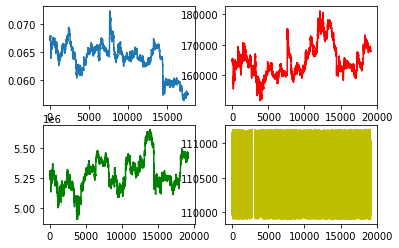

In [13]:
df.rename(columns = {'Unnamed: 0':'Date'},inplace=True)
plt.subplot(221)
plt.plot(df.index,df['SLP_price'])
plt.subplot(222)
plt.plot(df.index,df['Axie_price'],'r')
plt.subplot(223)
plt.plot(df.index,df['Ether_price'],'g')
plt.subplot(224)
plt.plot(df.index,df['Player_count'],'y')

plt.show()

#아무런 추가 전처리 없이 그래프를 그렸을때 보여지는 모습.
#접속중인 player_count가 높아졌다 낮아졌다를 계속해서 반복하므로, 정상적인 그래프가 그려지지 않는다.(즉 날짜별로는 그래프가 증가하거나 감소하지 않고 그저 진동한다.)
#date로 표시할경우 에러 발생


관계 분석, 그래프를 정확히 그리기 위해, 시계열 날짜 기준으로 보간

In [16]:
df['SLP_price']=pd.Series(df['SLP_price']).interpolate()
df['Player_count']=pd.Series(df['Player_count']).interpolate()
df['Ether_price']=pd.Series(df['Ether_price']).interpolate()
df['Axie_price']=pd.Series(df['Axie_price']).interpolate()



#reference  출처: https://rfriend.tistory.com/264
 

다음과 같이 값을 채우고 나서, 실제로 각각의 correlation 값이 어떤지 확인해보자.

              SLP_price  Axie_price  Ether_price  Player_count
SLP_price      1.000000    0.089363     0.212123      0.011985
Axie_price     0.089363    1.000000     0.658834     -0.028509
Ether_price    0.212123    0.658834     1.000000     -0.030434
Player_count   0.011985   -0.028509    -0.030434      1.000000


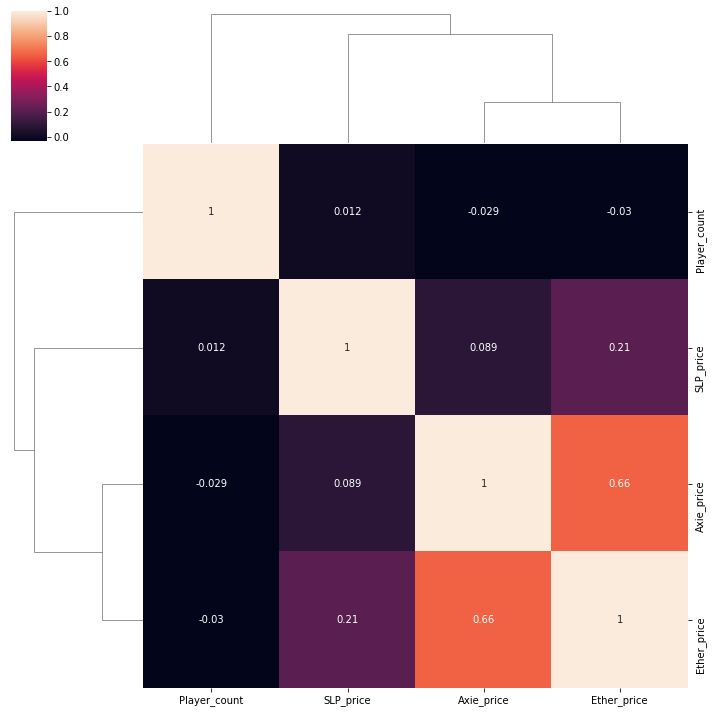

In [17]:
correlation=df.corr()
print(correlation)

sns.clustermap(correlation,annot=True)

#corr_data=df.pivot("SLP_price","Player_count","Ether_price","Axie_price")

#참고 자료: https://m.blog.naver.com/kiddwannabe/221763497317 


다음 heatmap을 보면, player_count와 다른 코인가격과는 거의 0에 가까운 상관 관계를 가짐을 볼 수 있다.

오히려 서로 높은 상관관계를 갖는 엑시 인피니티와 이더리움의 상관관계가 높으므로 유저수와 관계없이 이더리움의 가격에 따라 가격이 변동된다는 것을 알 수 있다. 또한 게임 내부재화인 SLP와 유저 수와도 관계가 없는것으로 보아 각 코인들은 사용자의 수와는 관계가 없는것으로 보여진다.

그렇다면, 장기적으로 봤을때, 이더리움 가격과 엑시 인피니티 코인의 가격은 어떻게될까? 선형 분석을 통해서 장기투자의 가능성이 있는지 확인해보았다.



In [37]:
#import module
from sklearn.linear_model import LinearRegression
from datetime import datetime



date_time_series=pd.to_datetime(df['Date'])
date_time_series=date_time_series.astype(int).to_numpy()

linear_filter=LinearRegression()
linear_filter.fit(date_time_series.reshape(-1,1),df['Ether_price'])
#시간 흐름과 이더리움 가격을 선형 분석

time_range=pd.date_range("01/12/2021","30/12/2021",freq="min")
time_range=time_range.astype(int).to_numpy()

y=linear_filter.predict(time_range.reshape(-1,1))
print(y)

#참고: https://jlim0316.tistory.com/42

[1610409600000000000 1610409660000000000 1610409720000000000 ...
 1640822280000000000 1640822340000000000 1640822400000000000]
[1371329.09783053 1371337.71497381 1371346.33211708 ... 5739169.44605052
 5739178.0631938  5739186.68033707]




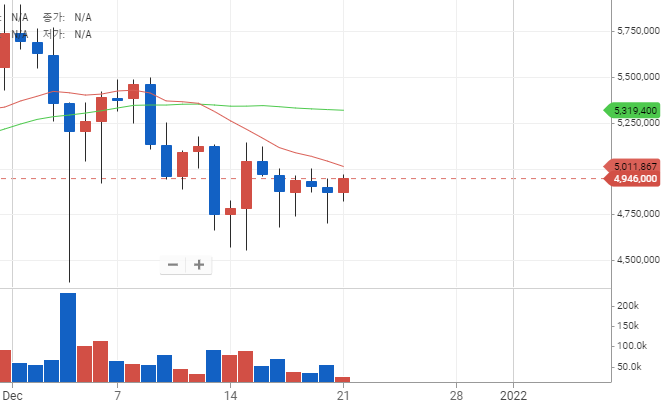

실제로도 선형회귀로 만든 차트와는 반대로 하향하는 그래프를 볼 수 있다.(선형회귀에서는 단조증가중)

랜덤성이 높은 주식차트를 하나의  선형분석으로 분석하는것은 바람직 하지 않다. 값이 선형적으로 떨어지게 증가하거나, 감소하지 않기때문이다. 실제 주식 데이터를 분석할때는 딥러닝 기법이 많이쓰인다고 하나 수업에서 배운적이 없어 따로 써보지는 않았다.

주식 분석에 쓰이는 기법들 모음:https://tbacking.com/2020/11/01/%EC%A3%BC%EC%8B%9D-%EC%98%88%EC%B8%A1-%EA%B4%80%EB%A0%A8-%EB%85%BC%EB%AC%B8-%EC%A0%95%EB%A6%AC/

사진 출처:https://upbit.com/exchange?code=CRIX.UPBIT.KRW-ETH